In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [2]:
# import warnings
# warnings.filterwarnings("default")

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Astro"]

In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 3013 cells


In [9]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

In [10]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX']:
        new_sub_annotation.append('Astro_AMY_CTX')
    elif c in ['Astro_THAL_hab', 'Astro_THAL_lat', 'Astro_THAL_med']:
        new_sub_annotation.append('Astro_THAL')
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#### Data preparation

In [11]:
sf.data_preparation(obj)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#### Data split

In [12]:
s = time.time()

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
data = obj.X.copy()

myDict = {}
for idx, c in enumerate(obj.obs["Cell sub annotation"].cat.categories):
    myDict[c] = idx

labels = []
for l in obj.obs["Cell sub annotation"].tolist():
    labels.append(myDict[l])

labels = np.array(labels)

X = data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### RankCorr

In [15]:
sys.path.append("../../../../../Functions/RankCorr/")
from picturedRocks import Rocks

In [16]:
genes = obj.var.index.tolist()

In [17]:
data = Rocks(X_train, y_train)
markers = data.CSrankMarkers(lamb=3.0, writeOut=False, keepZeros=False, onlyNonZero=False)
data.genes = np.array(genes)

In [18]:
marker_genes = data.markers_to_genes(markers)

In [19]:
selectedGenes = [x for x in marker_genes if x != 'nan'][:30]

In [20]:
selectedGenes_dict = {}
selectedGenes_dict["group"] = selectedGenes

In [21]:
e = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

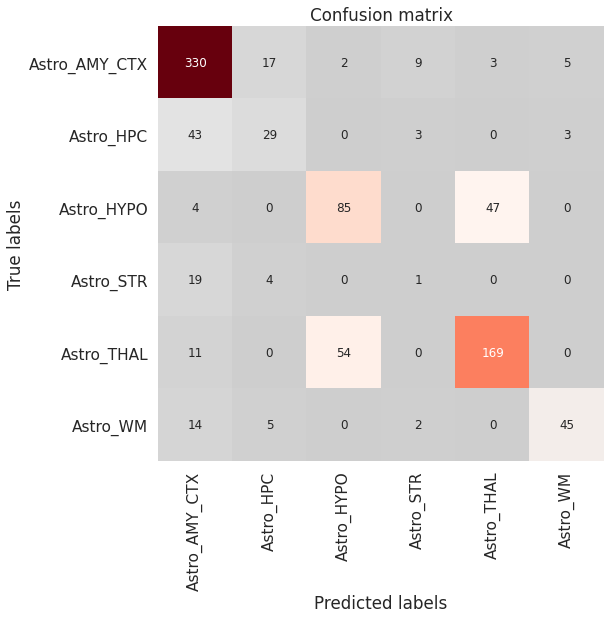

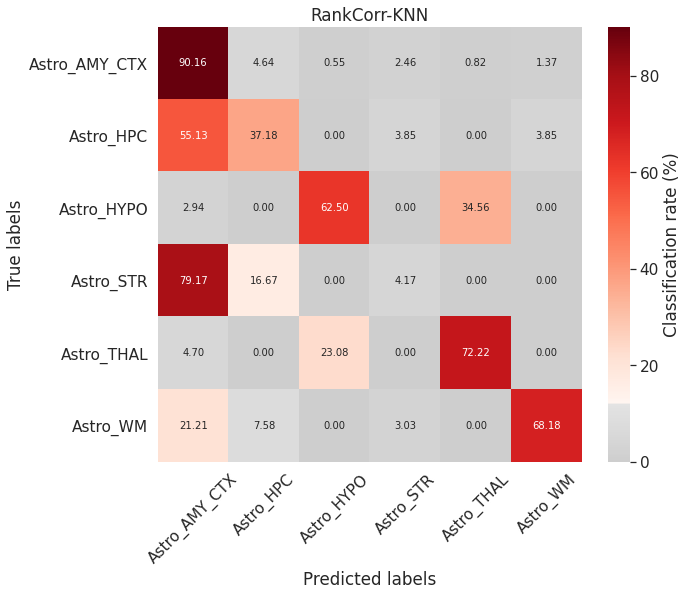

Accuracy: 0.7289823008849557: Misclassification: 0.27101769911504425
               precision    recall  f1-score   support

Astro_AMY_CTX       0.78      0.90      0.84       366
    Astro_HPC       0.53      0.37      0.44        78
   Astro_HYPO       0.60      0.62      0.61       136
    Astro_STR       0.07      0.04      0.05        24
   Astro_THAL       0.77      0.72      0.75       234
     Astro_WM       0.85      0.68      0.76        66

     accuracy                           0.73       904
    macro avg       0.60      0.56      0.57       904
 weighted avg       0.72      0.73      0.72       904



In [22]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="RankCorr-KNN")

#### Heatmap selected genes

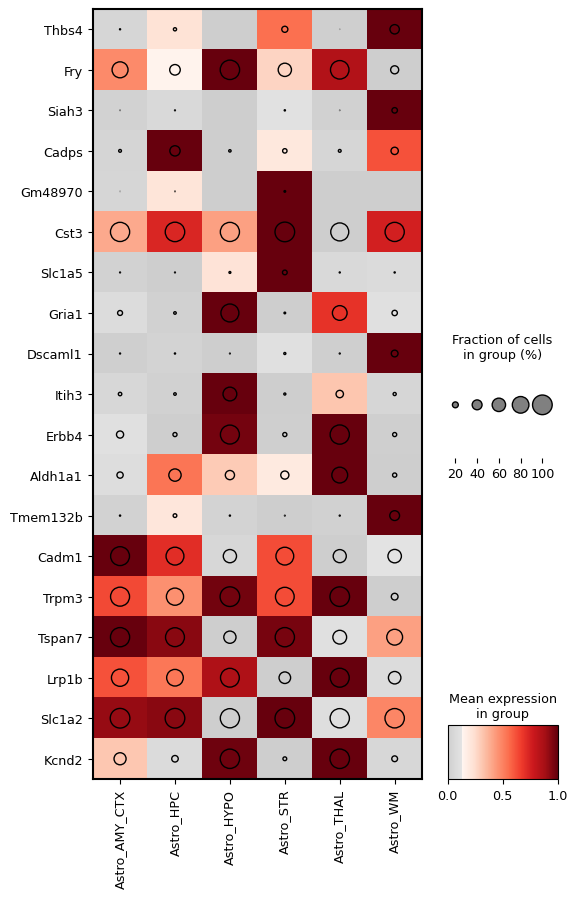

In [23]:
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 11})
ax = sc.pl.DotPlot(obj,
                   selectedGenes,
                   groupby="Cell sub annotation",
                   standard_scale='var',
                   use_raw=True,
                   figsize=(6,10),
                   linewidths=2).style(cmap=mymap, color_on='square', grid=True, dot_edge_lw=1)
ax.swap_axes(swap_axes=True)
# ax.show()

ax.savefig("Figures/RankCorr_top30.pdf")

# Elapsed time

In [24]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 3013 cells


In [25]:
print('Elapsed time (s): ', e-s)

Elapsed time (s):  10.372875213623047
